Install prerequisites and import appropriate functions

In [1]:
%pip install pandas matplotlib scikit-learn seaborn ipympl scipy
import pandas as pd
%matplotlib widget
#%matplotlib widget
#%matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from itertools import combinations
from scipy.signal import savgol_filter
from scipy.sparse import diags
from scipy.linalg import solve



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Read input CSV from the folder and print it to confirm successful read

In [2]:
df_pm = pd.read_csv('30-3-2023  -  11-25.csv',delimiter=',',header='infer')
df_pm

DateTime  Fidas 200 PM2.5  SPS30 PM2.5  SEN55 PM2.5  \
0       2023-3-30 11:26:3            20.49        15.90         17.0   
1       2023-3-30 11:26:9            20.49        16.26         17.3   
2      2023-3-30 11:26:15            20.49        16.99         17.5   
3      2023-3-30 11:26:20            20.49        17.14         17.7   
4      2023-3-30 11:26:26            20.50        17.52         17.8   
...                   ...              ...          ...          ...   
76002    2023-4-4 9:40:36             0.33         0.29          0.4   
76003    2023-4-4 9:40:42             0.33         0.35          0.4   
76004    2023-4-4 9:40:47             0.33         0.40          0.3   
76005    2023-4-4 9:40:53             0.34         0.44          0.3   
76006    2023-4-4 9:40:59             0.34         0.45          0.3   

       HPMA115 PM2.5  NextPM PM2.5  SDS011 PM2.5  
0                 36           0.0          10.2  
1                 36           0.0          10.1  
2                 17           0.0          10.2  
3                 16           0.0           9.9  
4                 16           0.0          10.1  
...              ...           ...           ...  
76002              0           0.2           0.5  
76003              0           0.3           0.5  
76004              0           1.8           0.5  
76005              0           1.7           0.5  
76006              0           0.2           0.5  

[76007 rows x 7 columns]

Define deployed sensors, drop non deployed sensors, convert first column to pandas datetime remove any erroneous values

In [3]:
# define the array of deployed sensors
deployed_sensors = ['Fidas 200 PM2.5', 'SPS30 PM2.5', 'SEN55 PM2.5', 'HPMA115 PM2.5', 'NextPM PM2.5', 'SDS011 PM2.5']
no_fidas = [x for x in deployed_sensors if x != 'Fidas 200 PM2.5']

# loop over all columns in the dataframe and drop any that are not in the columns_to_keep array, except for 'DateTime'
for col in df_pm.columns:
    if col not in deployed_sensors and col != 'DateTime':
        df_pm = df_pm.drop(col, axis=1)
df_pm['DateTime'] = pd.to_datetime(df_pm.DateTime)

# filter the dataframe to exclude rows with negative values in deployed_sensors columns
df_pm = df_pm.loc[~(df_pm[deployed_sensors] < 0).any(axis=1)]
df_pm = df_pm.tail(15000)
df_pm

DateTime  Fidas 200 PM2.5  SPS30 PM2.5  SEN55 PM2.5  \
60988 2023-04-03 10:19:07             0.25         0.25          0.2   
60989 2023-04-03 10:19:13             0.25         0.22          0.2   
60990 2023-04-03 10:19:18             0.25         0.19          0.2   
60991 2023-04-03 10:19:24             0.25         0.22          0.1   
60992 2023-04-03 10:19:29             0.25         0.25          0.1   
...                   ...              ...          ...          ...   
76002 2023-04-04 09:40:36             0.33         0.29          0.4   
76003 2023-04-04 09:40:42             0.33         0.35          0.4   
76004 2023-04-04 09:40:47             0.33         0.40          0.3   
76005 2023-04-04 09:40:53             0.34         0.44          0.3   
76006 2023-04-04 09:40:59             0.34         0.45          0.3   

       HPMA115 PM2.5  NextPM PM2.5  SDS011 PM2.5  
60988              1           0.0           0.5  
60989              1           0.1           0.5  
60990              0           0.1           0.5  
60991              0           0.0           0.5  
60992              0           0.0           0.5  
...              ...           ...           ...  
76002              0           0.2           0.5  
76003              0           0.3           0.5  
76004              0           1.8           0.5  
76005              0           1.7           0.5  
76006              0           0.2           0.5  

[15000 rows x 7 columns]

Plot initial graph

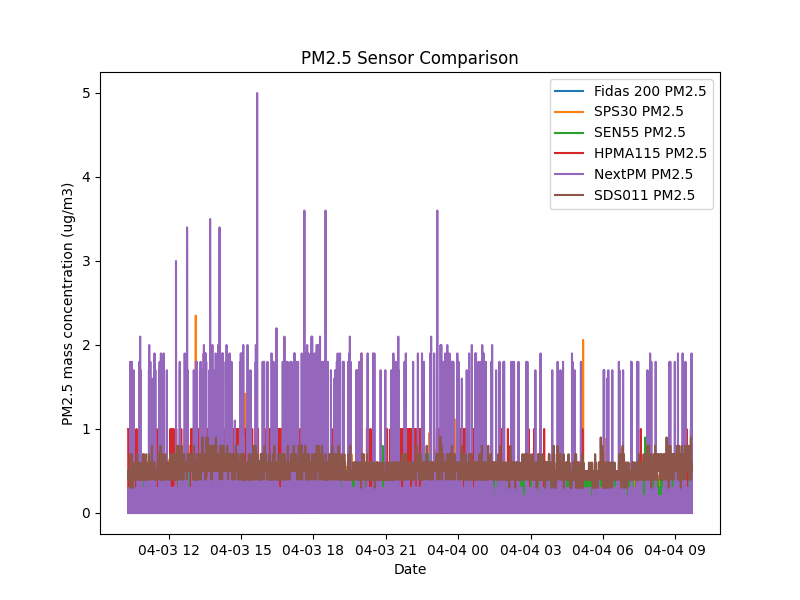

In [4]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Plot every pair of sensors against each other

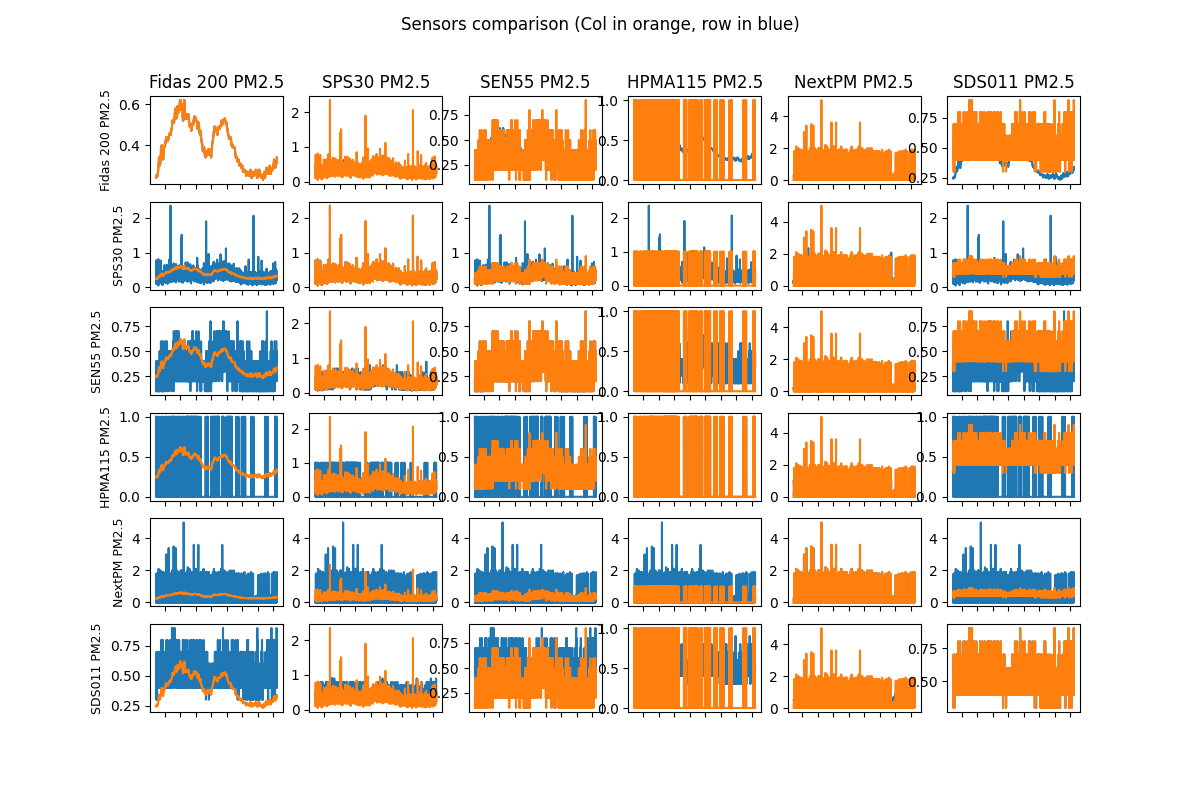

In [5]:

# create a figure object with subplots
fig, axs = plt.subplots(len(deployed_sensors), len(deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(deployed_sensors)):
    for j in range(len(deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

Plot correlation matrix

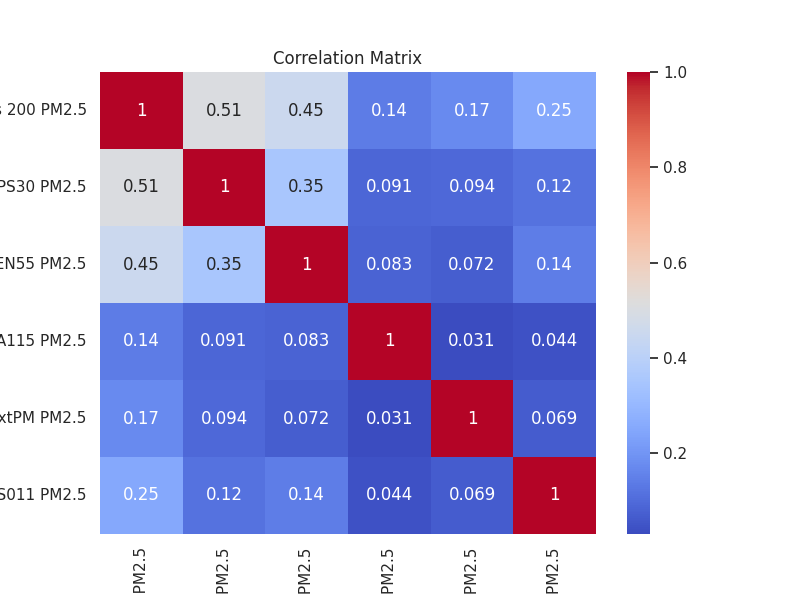

In [6]:
# create a correlation matrix for the selected columns
corr = df_pm[deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Calculate r squared between all sensors


In [7]:
# create an empty list to store the R-squared values
r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5' and 'SEN55 PM2.5': -0.2652707903909357
R-squared between 'Fidas 200 PM2.5' and 'SPS30 PM2.5': -0.4617561028247983
R-squared between 'Fidas 200 PM2.5' and 'SEN55 PM2.5': -0.562174361526572
R-squared between 'NextPM PM2.5' and 'SDS011 PM2.5': -1.222867661554285
R-squared between 'Fidas 200 PM2.5' and 'SDS011 PM2.5': -1.550006689604408
R-squared between 'HPMA115 PM2.5' and 'NextPM PM2.5': -2.571618381618382
R-squared between 'SPS30 PM2.5' and 'SDS011 PM2.5': -3.503501698817651
R-squared between 'SEN55 PM2.5' and 'SDS011 PM2.5': -3.6874008024381135
R-squared between 'HPMA115 PM2.5' and 'SDS011 PM2.5': -5.194145854145854
R-squared between 'SPS30 PM2.5' and 'HPMA115 PM2.5': -9.179898423861884
R-squared between 'SPS30 PM2.5' and 'NextPM PM2.5': -9.372057457548072
R-squared between 'SEN55 PM2.5' and 'HPMA115 PM2.5': -9.588913813846151
R-squared between 'SEN55 PM2.5' and 'NextPM PM2.5': -9.927229709121313
R-squared between 'Fidas 200 PM2.5' and 'NextPM PM2.5': -1

Perform data smoothing

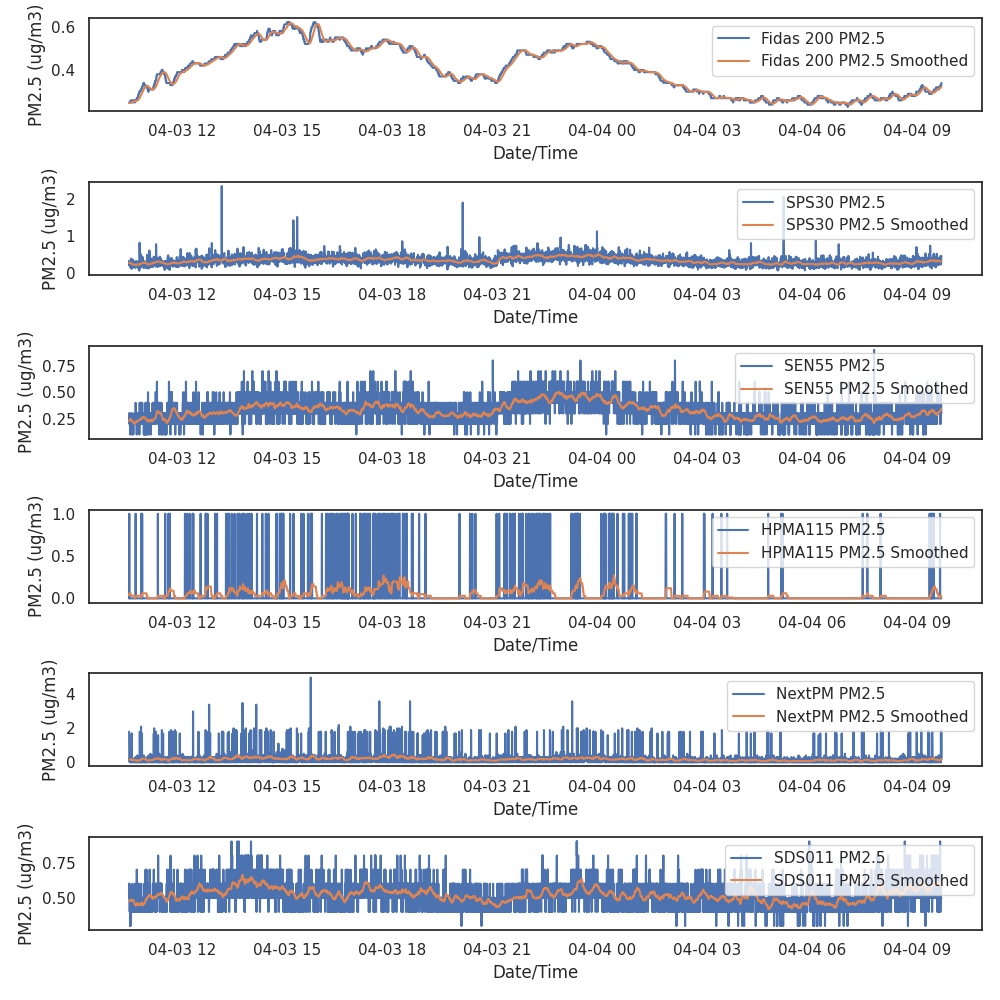

In [8]:
numtoaverage = 100

# loop through each column and perform a 30 point rolling average
for col in deployed_sensors:
    df_pm[f"{col} Smoothed"] = df_pm[col].rolling(window=numtoaverage).mean()

# drop the first 30 rows to avoid NaN values
df_pm = df_pm.iloc[numtoaverage:]

# plot the original and smoothed values for each column
fig, axes = plt.subplots(nrows=len(deployed_sensors), ncols=1, figsize=(10,10))
for i, col in enumerate(deployed_sensors):
    ax = axes[i]
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)
    ax.plot(df_pm['DateTime'], df_pm[f"{col} Smoothed"], label=f"{col} Smoothed")
    ax.set_xlabel('Date/Time')
    ax.set_ylabel('PM2.5 (ug/m3)')
    ax.legend()
plt.tight_layout()
plt.show()






Evaluate correlation for each smoothed element

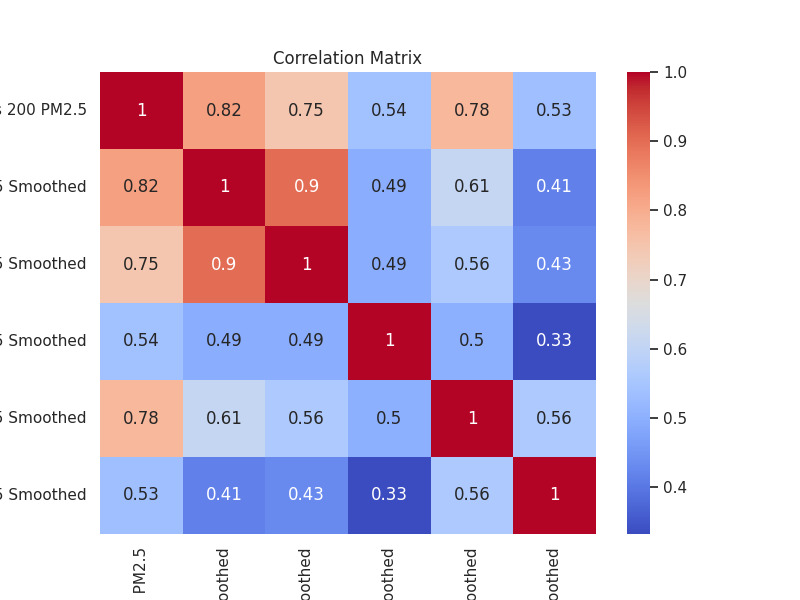

In [9]:
smoothed_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " Smoothed" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']


# create a correlation matrix for the selected columns
corr2 = df_pm[smoothed_deployed_sensors].corr()

# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Evaluate R Squared for smoothed data

In [10]:
# create an empty list to store the R-squared values
smoothed_r_squared_list = []

# loop through all possible combinations of columns and calculate R-squared
for pair in combinations(smoothed_deployed_sensors, 2):
    x_col = df_pm[pair[0]]
    y_col = df_pm[pair[1]]
    r_squared = r2_score(x_col, y_col)
    smoothed_r_squared_list.append((pair[0], pair[1], r_squared))

# sort the list of R-squared values in descending order
smoothed_r_squared_list.sort(key=lambda x: x[2], reverse=True)

# print the R-squared values
for r in smoothed_r_squared_list:
    print(f"R-squared between '{r[0]}' and '{r[1]}': {r[2]}")

R-squared between 'SPS30 PM2.5 Smoothed' and 'SEN55 PM2.5 Smoothed': 0.803931314679774
R-squared between 'Fidas 200 PM2.5' and 'SPS30 PM2.5 Smoothed': 0.189278295490781
R-squared between 'Fidas 200 PM2.5' and 'SEN55 PM2.5 Smoothed': 0.06705799423668757
R-squared between 'Fidas 200 PM2.5' and 'SDS011 PM2.5 Smoothed': -1.0210086793188955
R-squared between 'Fidas 200 PM2.5' and 'NextPM PM2.5 Smoothed': -3.688912418357698
R-squared between 'SPS30 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -4.520042033708168
R-squared between 'SEN55 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -4.940907957842101
R-squared between 'HPMA115 PM2.5 Smoothed' and 'NextPM PM2.5 Smoothed': -5.226349454463939
R-squared between 'SPS30 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -7.786590987522965
R-squared between 'SEN55 PM2.5 Smoothed' and 'SDS011 PM2.5 Smoothed': -8.55143979557623
R-squared between 'Fidas 200 PM2.5' and 'HPMA115 PM2.5 Smoothed': -10.052883836007043
R-squared between 'SPS30 PM2.5 Smoothed' and '

Plot smoothed data against each other

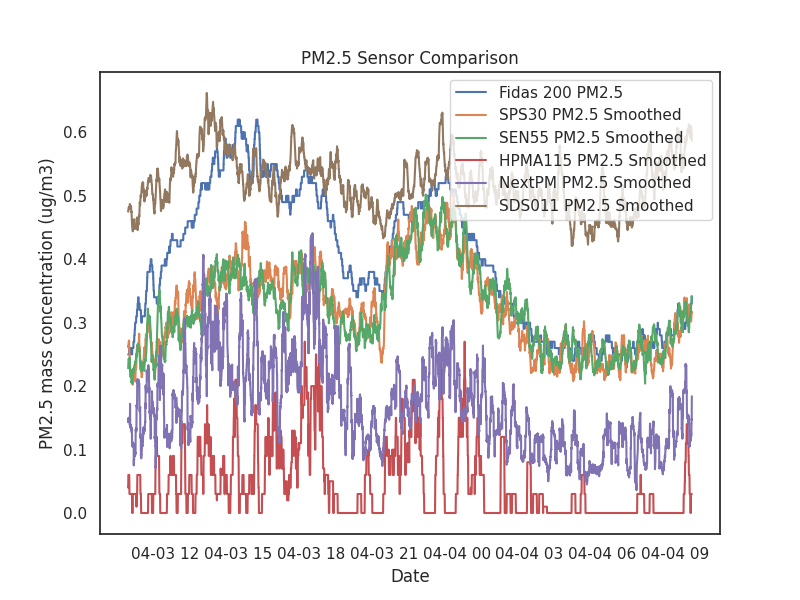

In [11]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in smoothed_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

Run mass plotting again with smoothed data

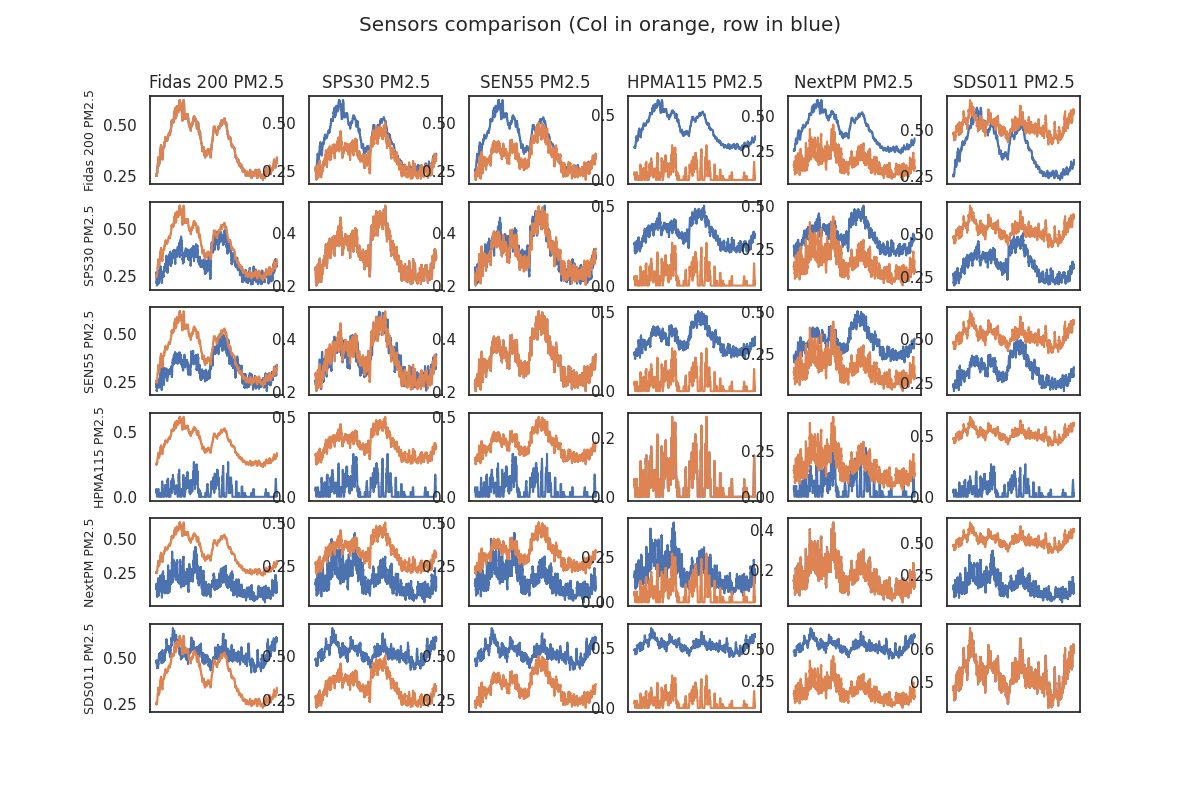

In [12]:
# create a figure object with subplots
fig, axs = plt.subplots(len(smoothed_deployed_sensors), len(smoothed_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(smoothed_deployed_sensors)):
    for j in range(len(smoothed_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[smoothed_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()


Experiment with new denoising algos

RMSE :  0.36132605095767883
R-squared : -9.987516376105894


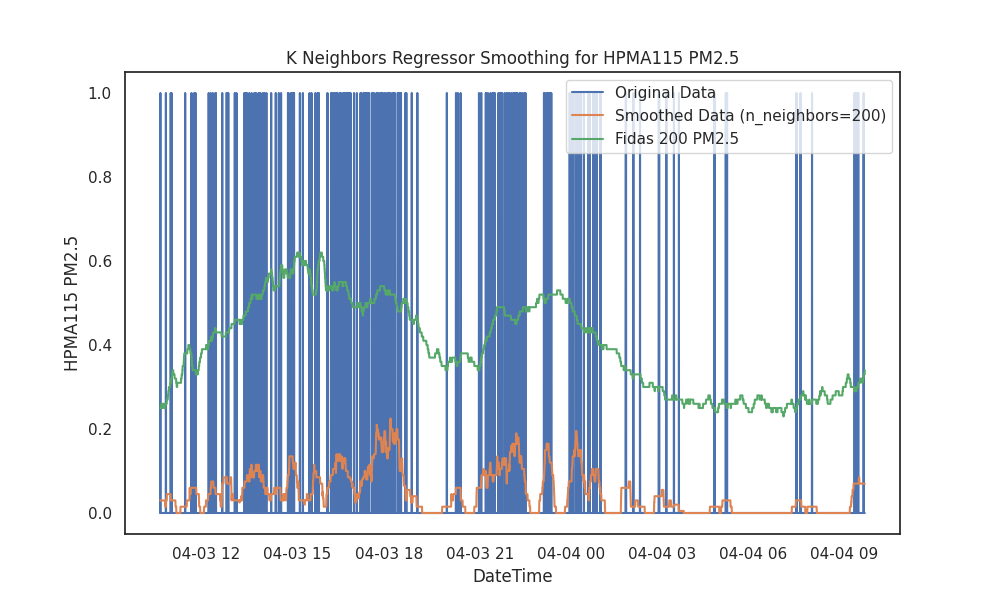

In [13]:
sensor_to_eval = 'HPMA115 PM2.5'

# extract the input features and target variable
X = df_pm[['DateTime']]   # input features
y = df_pm[sensor_to_eval]  # target variable

# create an instance of the KNN regressor
knn = KNeighborsRegressor(n_neighbors=200)

# fit the model to the data
knn.fit(X, y)

# make predictions on the input features
y_pred = knn.predict(X)

rmse = mean_squared_error(df_pm['Fidas 200 PM2.5'], y_pred , squared=False)
r2 = r2_score(df_pm['Fidas 200 PM2.5'], y_pred )
print('RMSE : ', rmse)
print('R-squared :', r2)

plt.figure(figsize=(10, 6))
plt.plot(df_pm['DateTime'], y, label='Original Data')
plt.plot(df_pm['DateTime'], y_pred, label='Smoothed Data (n_neighbors=200)')
plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas 200 PM2.5')
plt.xlabel('DateTime')
plt.ylabel(sensor_to_eval)
plt.title('K Neighbors Regressor Smoothing for {}'.format(sensor_to_eval))
plt.legend()
plt.show()

# Incinerate laptop

Run KNN data smoothing on each sample, find the best neighbours value, plot graph and store in original dataframe

In [14]:

sensor_to_eval = 'NextPM PM2.5'

for col in no_fidas:
    sensor_to_eval = col
    # Extract the datetime column and sensor column
    datetime_col = df_pm['DateTime']
    sensor_col = df_pm[sensor_to_eval]

    # Define the range of n_neighbors values to iterate over
    n_neighbors_range = [200]

    # Initialize an empty array to store the smoothed data for each n_neighbors value
    smoothed_data = []WB830898717GB
    r2_values = []

    # Loop through the n_neighbors values and apply KNeighborsRegressor for each value
    for n_neighbors in n_neighbors_range:
        # Initialize the KNeighborsRegressor with the specified n_neighbors value
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        # Fit the model with the original sensor data
        knn.fit(datetime_col.values.reshape(-1, 1), sensor_col.values)
        # Predict the smoothed sensor data using the model
        smoothed_sensor_data = knn.predict(datetime_col.values.reshape(-1, 1))
        # Append the smoothed data to the list of smoothed data
        smoothed_data.append(smoothed_sensor_data)

        rmse = mean_squared_error(df_pm['Fidas 200 PM2.5'], smoothed_sensor_data , squared=False)
        r2 = r2_score(df_pm['Fidas 200 PM2.5'], smoothed_sensor_data )
        rmse_values.append(rmse)
        r2_values.append(r2)

    # Find the lowest RMSE and highest R-squared values and their corresponding neighbors value
    min_rmse = min(rmse_values)
    max_r2 = max(r2_values)
    best_neighbors_rmse = n_neighbors_range[rmse_values.index(min_rmse)]
    best_neighbors_r2 = n_neighbors_range[r2_values.index(max_r2)]

    # Print the results
    print('Lowest RMSE: {:.4f}, Neighbors: {}'.format(min_rmse, best_neighbors_rmse))
    print('Highest R-squared: {:.4f}, Neighbors: {}'.format(max_r2, best_neighbors_r2))

    # Plot the original and smoothed data on the same axis
    plt.figure(figsize=(10, 6))
    plt.plot(datetime_col, sensor_col, label='Original Data')

    plt.plot(datetime_col, smoothed_data[rmse_values.index(min_rmse)], label='Smoothed Data (n_neighbors={})'.format(n_neighbors_range[rmse_values.index(min_rmse)]))
    plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas 200 PM2.5')
    plt.xlabel('DateTime')
    plt.ylabel(sensor_to_eval)
    plt.title('K Neighbors Regressor Smoothing for {}'.format(sensor_to_eval))
    plt.legend()
    plt.show()
    df_pm[sensor_to_eval+' KNN'] = smoothed_data[rmse_values.index(min_rmse)]

SyntaxError: invalid syntax (4057430739.py, line 13)

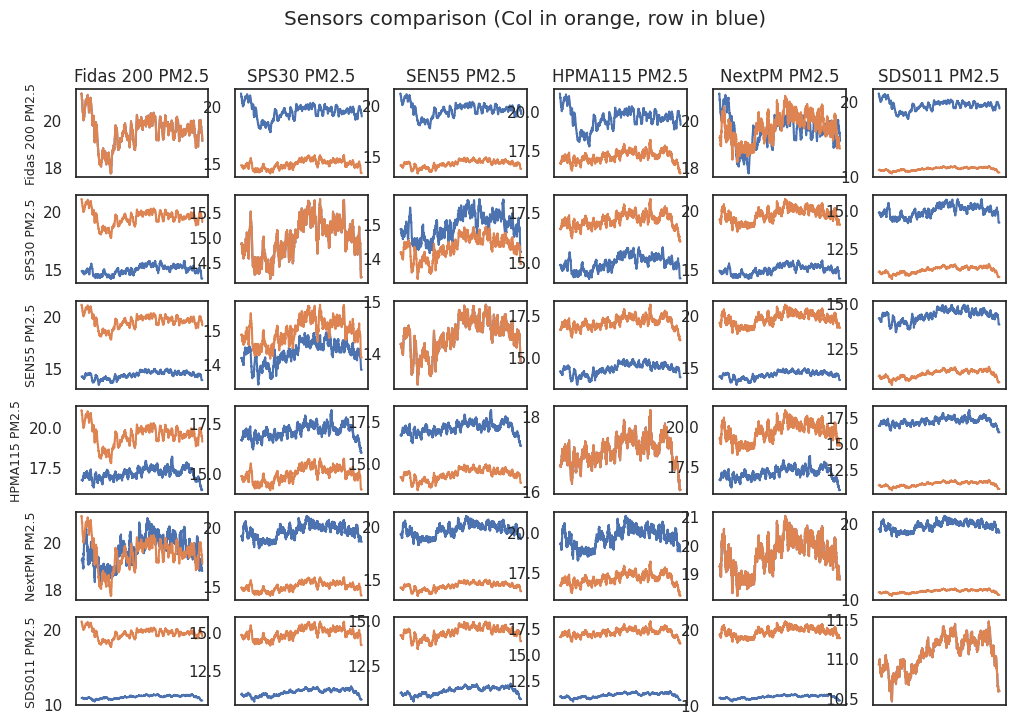

In [ ]:
knn_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " KNN" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']
fig, axs = plt.subplots(len(knn_deployed_sensors), len(knn_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(knn_deployed_sensors)):
    for j in range(len(knn_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[knn_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[knn_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

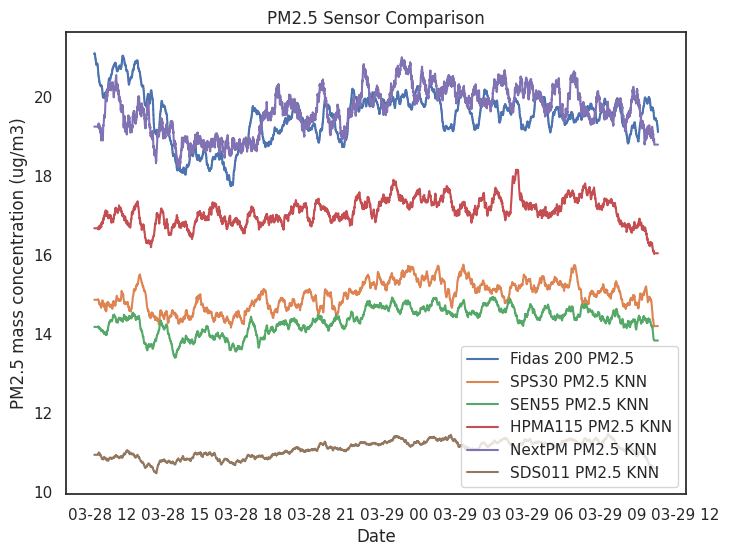

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in knn_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

In [ ]:
df_pm['Fidas 200 PM2.5'].describe()

count    14900.000000
mean        19.523787
std          0.623897
min         17.750000
25%         19.190000
50%         19.610000
75%         19.910000
max         21.120000
Name: Fidas 200 PM2.5, dtype: float64

# Incinerate laptop 2: electric boogaloo

Apply Savitsky-Golay filter to the data. Iterate lots of different values to try and find best parameters

RMSE :  4.592270887456211
R-squared : -53.18241973687701
R-order : 1
RMSE :  4.594873009785107
R-squared : -53.243839993706686
R-order : 2
RMSE :  4.595798764893215
R-squared : -53.26569982337043
R-order : 3
RMSE :  4.601073992680283
R-squared : -53.39034767433483
R-order : 4
RMSE :  4.600918037482125
R-squared : -53.38666057271254
R-order : 5
Best Window Size: 200
Best Polynomial Order: 1
Best RMSE: 4.5923
Best R-squared: -53.1824


/tmp/ipykernel_40801/3235479835.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


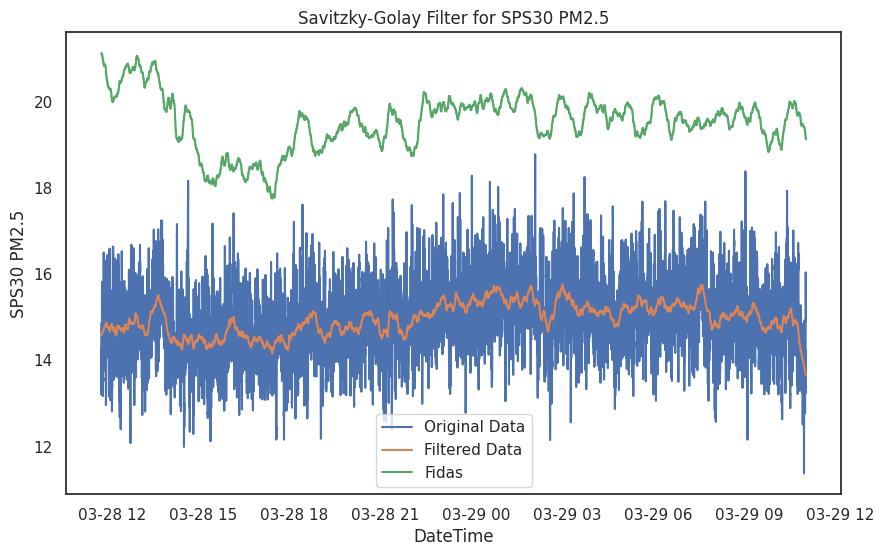

RMSE :  5.215806164703106
R-squared : -68.8950285472128
R-order : 1
RMSE :  5.217652541686727
R-squared : -68.94452249310757
R-order : 2
RMSE :  5.218489745035825
R-squared : -68.96697032227479
R-order : 3
RMSE :  5.2209520046208935
R-squared : -69.0330114547663
R-order : 4
RMSE :  5.220705485389855
R-squared : -69.02639807217831
R-order : 5
Best Window Size: 200
Best Polynomial Order: 1
Best RMSE: 5.2158
Best R-squared: -68.8950


/tmp/ipykernel_40801/3235479835.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


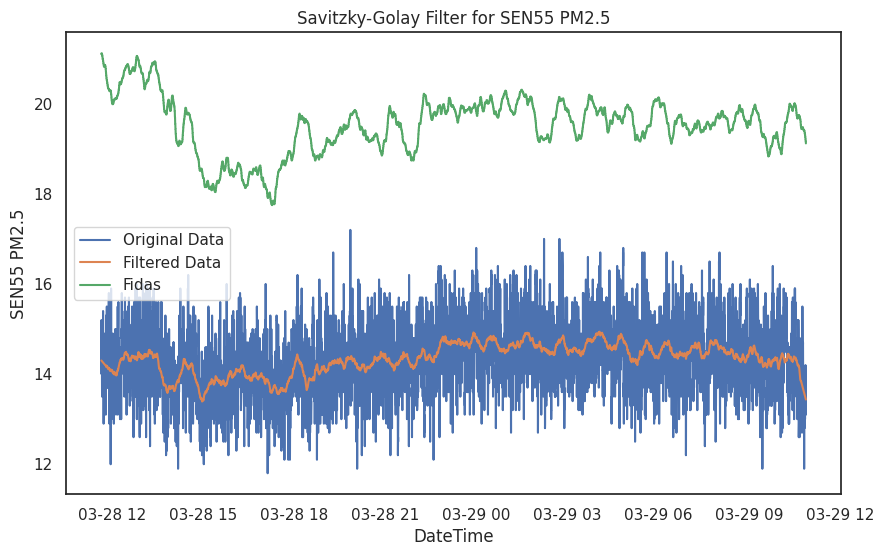

RMSE :  2.506491467111125
R-squared : -15.141201567915441
R-order : 1
RMSE :  2.5171338928594067
R-squared : -15.278561881282332
R-order : 2
RMSE :  2.5177764494251442
R-squared : -15.286873899893966
R-order : 3
RMSE :  2.528418078902864
R-squared : -15.424840995473595
R-order : 4
RMSE :  2.528289249522027
R-squared : -15.423167262632031
R-order : 5
Best Window Size: 200
Best Polynomial Order: 1
Best RMSE: 2.5065
Best R-squared: -15.1412


/tmp/ipykernel_40801/3235479835.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


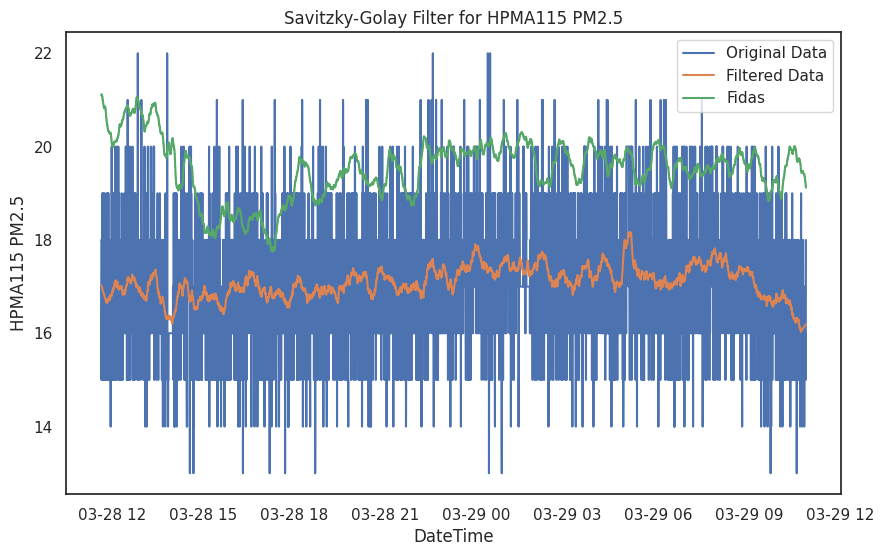

RMSE :  0.6009100235234671
R-squared : 0.07226851305137083
R-order : 1
RMSE :  0.7040993957899372
R-squared : -0.2737123015111307
R-order : 2
RMSE :  0.7039457403525325
R-squared : -0.27315643832815906
R-order : 3
RMSE :  0.7958576003772991
R-squared : -0.6273243997104709
R-order : 4
RMSE :  0.7955135177726407
R-squared : -0.62591758277152
R-order : 5
Best Window Size: 200
Best Polynomial Order: 1
Best RMSE: 0.6009
Best R-squared: 0.0723


/tmp/ipykernel_40801/3235479835.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


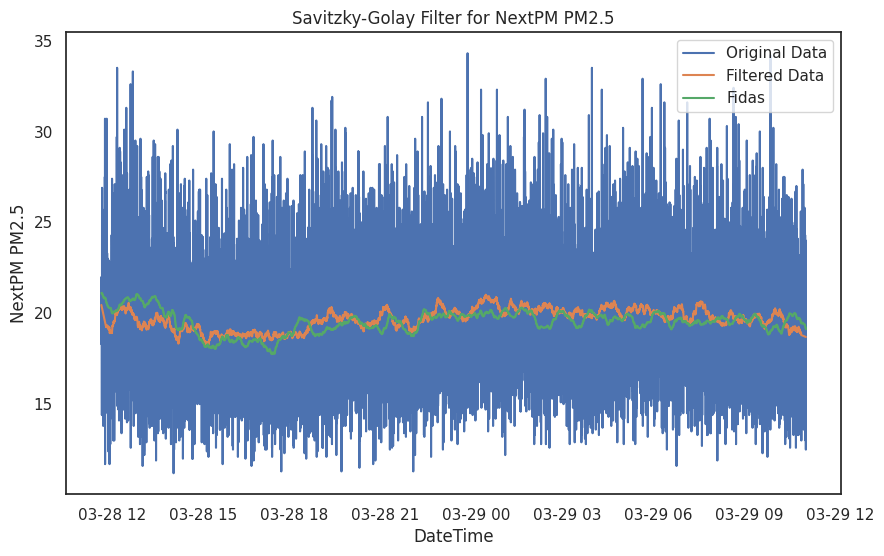

RMSE :  8.478401034395752
R-squared : -183.68486669913608
R-order : 1
RMSE :  8.478925156766945
R-squared : -183.70770130245432
R-order : 2
RMSE :  8.47870960377116
R-squared : -183.6983100667634
R-order : 3
RMSE :  8.47910754818337
R-squared : -183.7156479374318
R-order : 4
RMSE :  8.479142393666997
R-squared : -183.71716614421828
R-order : 5
Best Window Size: 200
Best Polynomial Order: 1
Best RMSE: 8.4784
Best R-squared: -183.6849


/tmp/ipykernel_40801/3235479835.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm[sensor_to_eval+' SavGol'] = smoothed_data


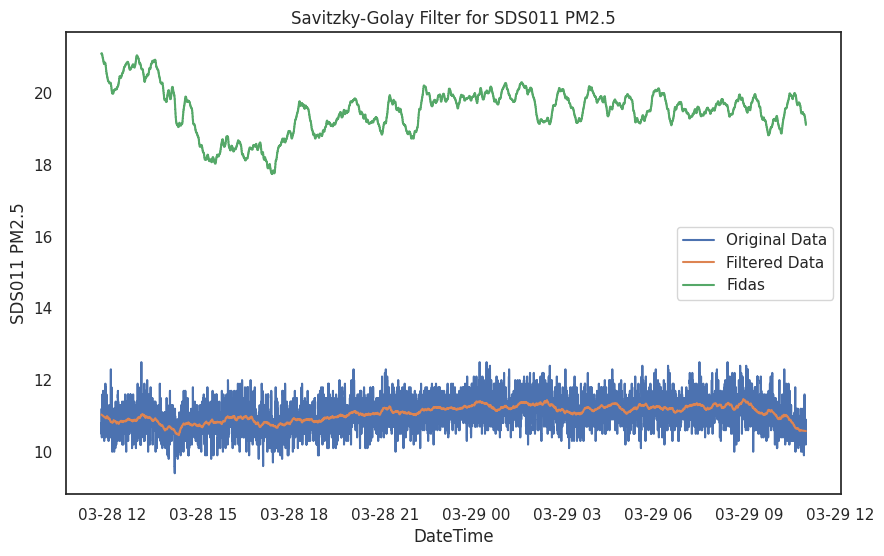

In [ ]:
ideal_data_col = 'Fidas 200 PM2.5'  # Column name for ideal data
sensor_to_eval = 'SPS30 PM2.5'  # Replace with the actual column name for noisy data

# Define the range of window sizes and polynomial order for Savitzky-Golay filter
#window_sizes = np.arange(10, 501, 10)  # Range of window sizes from 10 to 500 with step of 10
window_sizes = [200]
poly_orders = np.arange(1, 6, 1)  # Range of polynomial orders from 1 to 5

for col in no_fidas:
    sensor_to_eval = col

    # Initialize variables to store the best parameters and error metrics
    best_window_size = None
    best_poly_order = None
    best_rmse = float('inf')
    best_r2 = float('-inf')

    # Loop through all possible combinations of window sizes and polynomial orders
    for window_size in window_sizes:
        for poly_order in poly_orders:
            # Apply Savitzky-Golay filter on the noisy data
            smoothed_data = savgol_filter(df_pm[sensor_to_eval], window_size, poly_order)
            
            # Calculate RMSE and R-squared between smoothed data and ideal data
            rmse = np.sqrt(mean_squared_error(df_pm[ideal_data_col], smoothed_data))
            r2 = r2_score(df_pm[ideal_data_col], smoothed_data)
            
            # Update the best parameters and error metrics if necessary
            if rmse < best_rmse:
                best_rmse = rmse
                best_window_size = window_size
                best_poly_order = poly_order
            
            if r2 > best_r2:
                best_r2 = r2
                best_window_size = window_size
                best_poly_order = poly_order
            
            print('RMSE : ', rmse)
            print('R-squared :', r2)
            print('R-order :', poly_order)


    # Print the best parameters and error metrics
    print('Best Window Size: {}'.format(best_window_size))
    print('Best Polynomial Order: {}'.format(best_poly_order))
    print('Best RMSE: {:.4f}'.format(best_rmse))
    print('Best R-squared: {:.4f}'.format(best_r2))

    # Apply Savitzky-Golay filter on the noisy data
    smoothed_data = savgol_filter(df_pm[sensor_to_eval], best_window_size, best_poly_order)
    df_pm[sensor_to_eval+' SavGol'] = smoothed_data
    # plot the original and filtered data on the same axis
    plt.figure(figsize=(10, 6))
    plt.plot(df_pm['DateTime'], df_pm[sensor_to_eval], label='Original Data')
    plt.plot(df_pm['DateTime'], smoothed_data, label='Filtered Data')
    plt.plot(df_pm['DateTime'], df_pm['Fidas 200 PM2.5'], label='Fidas')
    plt.xlabel('DateTime')
    plt.ylabel(sensor_to_eval)
    plt.legend()
    plt.title('Savitzky-Golay Filter for {}'.format(sensor_to_eval))
    plt.show()

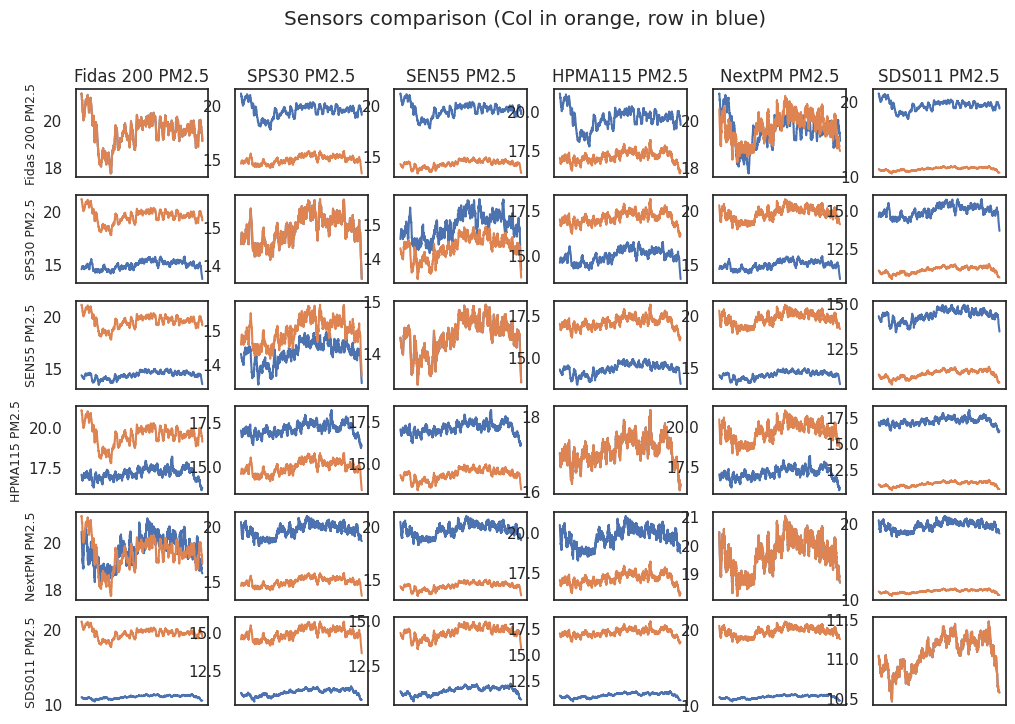

In [ ]:
savgol_deployed_sensors = ['Fidas 200 PM2.5'] + [elem + " SavGol" for elem in deployed_sensors if elem != 'Fidas 200 PM2.5']
fig, axs = plt.subplots(len(savgol_deployed_sensors), len(savgol_deployed_sensors), figsize=(12, 8), sharex=True)

# loop through all pairs of columns to plot
for i in range(len(savgol_deployed_sensors)):
    for j in range(len(savgol_deployed_sensors)):
        # plot the columns on the subplot
        if(i==0):
            axs[i, j].set_title(deployed_sensors[j])
        if(j==0):
            axs[i, j].set_ylabel(deployed_sensors[i], fontsize=9)
        axs[i, j].plot(df_pm['DateTime'], df_pm[savgol_deployed_sensors[i]], label=deployed_sensors[i])
        axs[i, j].plot(df_pm['DateTime'], df_pm[savgol_deployed_sensors[j]], label=deployed_sensors[j])
        axs[i, j].xaxis.set_ticklabels([])
        

# set the plot title
fig.suptitle('Sensors comparison (Col in orange, row in blue)')

# adjust the layout of the subplots
#plt.tight_layout()

# show the plot
plt.show()

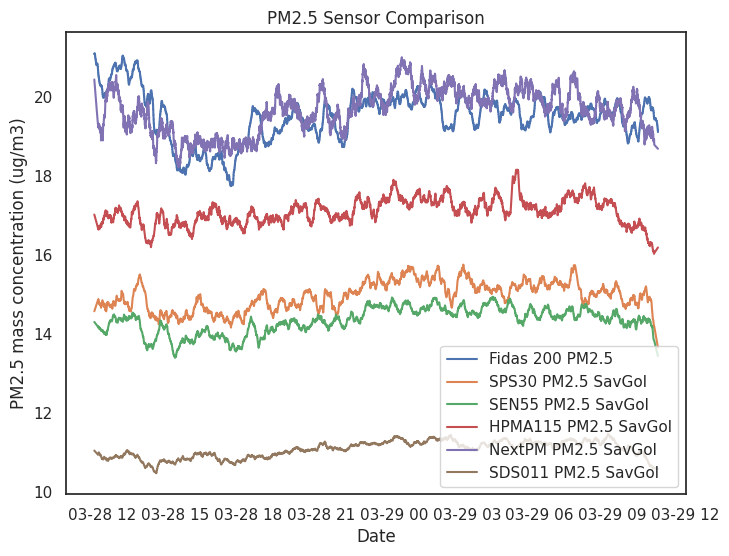

In [ ]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(8,6))

# plot each column using a for loop
for col in savgol_deployed_sensors:
    ax.plot(df_pm['DateTime'], df_pm[col], label=col)

# add a legend to the plot
ax.legend()

# set plot title and axis labels
plt.title('PM2.5 Sensor Comparison')
plt.xlabel('Date')
plt.ylabel('PM2.5 mass concentration (ug/m3)')

# show the plot
plt.show()

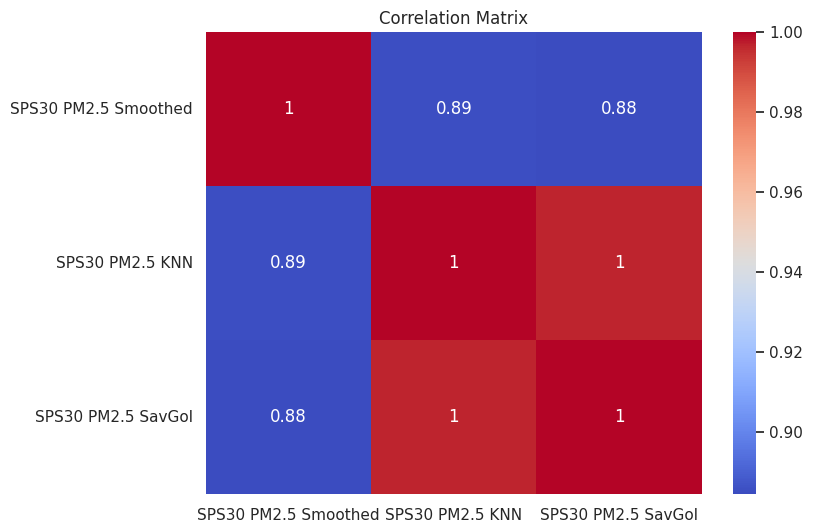

In [ ]:
col = 'SPS30 PM2.5'
a = col + ' Smoothed'
b = col + ' KNN'
c = col + ' SavGol'
corr2 = df_pm[[a, b, c]].corr()


# plot the correlation matrix
sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()